In [2]:
!git clone https://github.com/Churilinavalentina/diplom.git -b test_case

Cloning into 'diplom'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 13 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (13/13), done.


In [3]:
import csv
import math
import matplotlib.pyplot as plt
import numpy as np

Задаем параметры

In [4]:
Capital = 10000  # Первоначальный капитал
l = 0.5  # Коэффициент порового спреда
t = 22*13  # Количество временных интервалов для расчетов (22*13 - это 1 месяц). То есть в данном случае алгоритм сичтает, 
          # что заранее известны только данные за месяц, на основе их анализа он принимает решения. 
          # Данные за остальное время изначально считаются неизвестными, на них демонстрируется работоспособность алгоритма.
tax = 0.0005 # Доля которую удерживает брокер при сделке

Выбираем датасет

Кейс Сбербанк

In [5]:
a = []
b = []

with open('/content/diplom/SBER_200101_211201_1hour.csv', newline='') as File:
    reader = csv.reader(File, delimiter = ";")
    for row in reader:
        a.append(row)
with open('/content/diplom/SBERP_200101_211201_1_hour.csv', newline='') as File:
    reader = csv.reader(File, delimiter = ",")
    for row in reader:
        b.append(row)

Тело программы

В конце алгоритм выдает, корреляюцию, последовательность сделок, доходность, на графике зеленым отмечены места совершения сделок.

Корреляция 0.9941488724742591
20200306 Продали 0 шт. привелигированных по цене 209.8 стоимость портфеля = 10000.0
20200306 Купили  45.0225 шт. обычных акций по цене 218.07 , остаток =  177.0343967125009 стоимость портфеля = 9990.181943425003
20211005 Продали  45.0225 шт. обычных по цене 362.35 стоимость портфеля = 16482.780320275004
20211005 Купили  49.024499999999996 шт. привелигированных по цене 331.6 , остаток =  218.1278581750048 стоимость портфеля = 16466.523796075006
Стоимость портфеля 14785.334216372505
Доходность портфеля при арбитраже 47.853342163725046 %
Доходность без арбитража 30.054191067214408 %


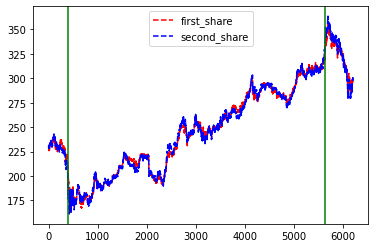

In [6]:
from re import L
first_share = []
second_share = []
Axis = []

# Коэффициент нормировки
k = []

Summ_first_share = 0
Summ_second_share = 0
Summ_k = 0

# Преобразуем датасеты в списки
for i in range(len(b)-1):
    first_share.append(float(a[i+1][4]))
    second_share.append(float(b[i+1][4]))
    k.append(second_share[i]/first_share[i])
    Summ_first_share = Summ_first_share+first_share[i]
    Summ_second_share = Summ_second_share+second_share[i]
    Axis.append(a[i+1][2])

# Вычисляем средний коэффициент нормировки
k_summ = 0
for j in range(t):
    k_summ = k_summ + k[j]
k_srednee = k_summ / t

# Корреляция, спред
Delta_GR = 0
Delta_G2 = 0
Delta_R2 = 0
first_share_norm = []
Spred=[]

for i in range(len(first_share)):
    Delta_GR = Delta_GR + (first_share[i]- Summ_first_share/len(first_share))*(second_share[i]- Summ_second_share/len(second_share))
    Delta_G2 = Delta_G2 + (first_share[i]- Summ_first_share/len(first_share))**2
    Delta_R2 = Delta_R2 + (second_share[i]- Summ_second_share/len(second_share))**2
    if i > t-1:
        k_summ = 0
        for j in range(t):
            k_summ=k_summ+k[i-j]
        k_srednee = k_summ/t
    first_share_norm.append(first_share[i]*k_srednee)
    Spred.append(second_share[i] - first_share_norm[i])
cor = Delta_GR/((Delta_G2*Delta_R2)**0.5)
print('Корреляция', cor)

#  Считаем средний спред(пороговый) и "выполняем сделку"
summ_spred = 0
min_spred = 0
max_spred = 0
for j in range(t):
    summ_spred = summ_spred + math.fabs(Spred[j])
Sredn_spred = l*summ_spred/t

ind = 0
if second_share[1+t]-first_share_norm[1+t] < 0:
    ind = 1

Sdel = []
N_r = 0
N_g = 0
Prib = Capital
Stoim = Capital

for i in range(len(second_share)-t):
    summ_spred = 0
    for j in range(t):
        summ_spred = summ_spred + math.fabs(Spred[i+t-j])
    Sredn_spred = l*summ_spred/t
    if math.fabs(second_share[i+t]-first_share_norm[i+t])>(math.fabs(Sredn_spred)*l)  and (second_share[i+t]-first_share_norm[i+t])>0 \
            and ind == 0 and math.fabs(second_share[i+t]-first_share_norm[i+t]) > 2*Stoim*tax:
        Prib = Prib + N_r*second_share[i+t]*(1-tax)
        print(Axis[i+t],'Продали',N_r,'шт. привелигированных по цене',second_share[i+t],
              'стоимость портфеля =', Prib )
        N_r = 0
        N_g = Prib//first_share[i+t]*(1+tax)
        Prib = Prib - N_g*first_share[i+t]*(1+tax)
        Stoim = Prib + N_g*first_share[i+t]*(1-tax)
        ind = 1
        print(Axis[i+t],'Купили ',N_g,'шт. обычных акций по цене',first_share[i+t],', остаток = ',Prib,
              'стоимость портфеля =', Stoim)
        Sdel.append(i+t)
    if math.fabs(second_share[i+t]-first_share_norm[i+t]) > (math.fabs(Sredn_spred)*l) and (second_share[i+t]-first_share_norm[i+t])<0 \
            and ind == 1 and math.fabs(second_share[i+t]-first_share_norm[i+t]) > 2*Stoim*tax:
        Prib = Prib + N_g*first_share[i+t]*(1-tax)
        print(Axis[i+t],'Продали ',N_g,'шт. обычных по цене',first_share[i + t],
              'стоимость портфеля =', Prib)
        N_g = 0
        N_r = Prib//second_share[i+t]*(1+tax)
        Prib = Prib - N_r*second_share[i+t]*(1+tax)
        Stoim = Prib + N_r*second_share[i+t]*(1-tax)
        ind = 0
        print(Axis[i+t],'Купили ',N_r,'шт. привелигированных по цене',second_share[i + t],', остаток = ',Prib,
              'стоимость портфеля =', Stoim)
        Sdel.append(i + t)

print('Стоимость портфеля', Prib + N_g * first_share[len(first_share)-1] * (1-tax) + N_r*second_share[len(second_share)-1]*0.9995)
Prib = (Prib + N_g * first_share[len(first_share)-1] * (1-tax) + N_r*second_share[len(second_share)-1]*(1-tax)-Capital)/Capital*100
print('Доходность портфеля при арбитраже', Prib, '%')
print('Доходность без арбитража', (-second_share[t]+second_share[len(first_share)-1])/second_share[t+1]*100, '%')

# строим график
Axis1 = []
for i in range(len(b)-1):
    Axis1.append(i)
plt.plot(Axis1,second_share, 'r--', label = 'first_share')
plt.plot(Axis1,first_share_norm, 'b--', label = 'second_share')
for i in range(len(Sdel)):
    plt.axvline(x=Sdel[i], color='green')
plt.legend()
plt.show()